<a href="https://colab.research.google.com/github/John-Donahue-Research/TestGit/blob/master/stock_price_prediction_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet.

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [4]:
#!pip install tensorflow
# #-gpu==2.0.0-alpha0

In [6]:
#!pip install pandas-datareader

In [8]:
#!pip install graphviz

In [11]:
#!pip install pydot pydot-ng

In [12]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
#!pip install yfinance

In [15]:
import yfinance as yf
tickers = 'AAPL'

start_date = '1980-12-01'
end_date = '2018-12-31'

stock_data = yf.download(tickers, start_date, end_date)
#data.get_data_yahoo(tickers, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [16]:
stock_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200
1980-12-23,0.137835,0.138393,0.137835,0.137835,0.106524,46950400
1980-12-24,0.145089,0.145647,0.145089,0.145089,0.112130,48003200


In [17]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9.594000e+03
mean,6.570239,6.633169,6.502576,6.569085,5.904344,3.503355e+08
std,11.715884,11.815450,11.611073,11.714950,10.850623,3.470619e+08
min,0.049665,0.049665,0.049107,0.049107,0.037952,0.000000e+00
25%,0.262321,0.267857,0.257813,0.262589,0.219209,1.361954e+08
50%,0.415982,0.424107,0.408482,0.416295,0.344635,2.377956e+08
75%,6.472053,6.571607,6.349107,6.458840,5.468050,4.367706e+08
max,57.695000,58.367500,57.445000,58.017502,55.421486,7.421641e+09


In [18]:
stock_data_len = stock_data['Close'].count()
print(stock_data_len)

9594


I'm only interested in *close* prices

In [19]:
close_prices = stock_data.iloc[:, 1:2].values
print(close_prices)

[[ 0.128906  ]
 [ 0.12221   ]
 [ 0.113281  ]
 ...
 [39.30749893]
 [39.19250107]
 [39.63000107]]


Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [20]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['1980-12-01', '1980-12-02', '1980-12-03', '1980-12-04',
               '1980-12-05', '1980-12-08', '1980-12-09', '1980-12-10',
               '1980-12-11', '1980-12-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', length=9936, freq='B')


In [21]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

C:\Users\johnd\AppData\Local\Temp\ipykernel_1100\843666352.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices = stock_data.fillna(method='ffill')


In [22]:
close_prices.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200
1980-12-23,0.137835,0.138393,0.137835,0.137835,0.106524,46950400
1980-12-24,0.145089,0.145647,0.145089,0.145089,0.112130,48003200


The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [23]:
training_set = close_prices.iloc[:, 1:2].values

In [24]:
print(training_set)

[[ 0.128906  ]
 [ 0.12221   ]
 [ 0.113281  ]
 ...
 [39.30749893]
 [39.19250107]
 [39.63000107]]


In [25]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(9594, 1)


LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [26]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i-60:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [27]:
print(labels)

[0.00082292 0.00088033 0.00086119 ... 0.67317029 0.67119837 0.67870036]


In [28]:
print(features)

[[[1.35877808e-03]
  [1.24395912e-03]
  [1.09084976e-03]
  ...
  [1.12912279e-03]
  [9.66462474e-04]
  [8.80330974e-04]]

 [[1.24395912e-03]
  [1.09084976e-03]
  [1.13869111e-03]
  ...
  [9.66462474e-04]
  [8.80330974e-04]
  [8.22921429e-04]]

 [[1.09084976e-03]
  [1.13869111e-03]
  [1.19611777e-03]
  ...
  [8.80330974e-04]
  [8.22921429e-04]
  [8.80330974e-04]]

 ...

 [[9.67291289e-01]
  [9.82638231e-01]
  [9.85124614e-01]
  ...
  [6.94090152e-01]
  [6.77157095e-01]
  [6.48820992e-01]]

 [[9.82638231e-01]
  [9.85124614e-01]
  [1.00000000e+00]
  ...
  [6.77157095e-01]
  [6.48820992e-01]
  [6.73170287e-01]]

 [[9.85124614e-01]
  [1.00000000e+00]
  [9.95198745e-01]
  ...
  [6.48820992e-01]
  [6.73170287e-01]
  [6.71198371e-01]]]


Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

In [29]:
print(features.shape)

(9534, 60, 1)


## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [30]:
import tensorflow as tf

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

c:\Users\johnd\anaconda3\envs\CeCodeAI\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
!pip install plot_model

In [40]:
tf.keras.utils.plot_model(model, to_file='my_model.png')


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [34]:
# Run tensorboard with the logdir
#import os
#LOG_BASE_DIR = './log'
#os.makedirs(LOG_BASE_DIR, exist_ok=True)

In [35]:
#!ls -l log

## Load the Colab TensorBoard extention and start TensorBoard inline

In [36]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir {LOG_BASE_DIR}

## Define a TensorBoard callback

In [37]:
#import datetime
#logdir = os.path.join(LOG_BASE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [38]:
#from tensorflow.keras.callbacks import TensorBoard

#tbCallBack = TensorBoard(logdir,histogram_freq=1)

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [39]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [40]:
#import os
#print(os.environ)

In [41]:
#tf.test.gpu_device_name()

In [42]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [43]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)
end = time()

Epoch 1/20
298/298 [==============================] - 15s 20ms/step - loss: 0.0017
Epoch 2/20
298/298 [==============================] - 4s 14ms/step - loss: 8.6661e-04
Epoch 3/20
298/298 [==============================] - 5s 15ms/step - loss: 6.9893e-04
Epoch 4/20
298/298 [==============================] - 4s 15ms/step - loss: 6.7593e-04
Epoch 5/20
298/298 [==============================] - 4s 15ms/step - loss: 5.4660e-04
Epoch 6/20
298/298 [==============================] - 5s 15ms/step - loss: 5.5803e-04
Epoch 7/20
298/298 [==============================] - 4s 14ms/step - loss: 5.5779e-04
Epoch 8/20
298/298 [==============================] - 4s 15ms/step - loss: 5.3565e-04
Epoch 9/20
298/298 [==============================] - 5s 16ms/step - loss: 4.7768e-04
Epoch 10/20
298/298 [==============================] - 5s 16ms/step - loss: 4.9978e-04
Epoch 11/20
298/298 [==============================] - 5s 16ms/step - loss: 4.5782e-04
Epoch 12/20
298/298 [==============================] - 

In [44]:
print('Total training time {} seconds'.format(end - start))

Total training time 147.14630579948425 seconds


In [45]:
#  [samples, days, features]
print(features.shape)

(9534, 60, 1)


In [49]:
testing_start_date = '2019-01-01'
testing_end_date = '2019-04-10'

test_stock_data = yf.download(tickers, testing_start_date, testing_end_date)
#data.get_data_yahoo(tickers, testing_start_date, testing_end_date)

[*********************100%%**********************]  1 of 1 completed


In [50]:
test_stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-03,48.312500,49.125000,48.287498,48.837502,46.952118,93087200
2019-04-04,48.697498,49.092499,48.285000,48.922501,47.033836,76457200
2019-04-05,49.112499,49.275002,48.982498,49.250000,47.348701,74106400
2019-04-08,49.105000,50.057499,49.084999,50.025002,48.093784,103526800
2019-04-09,50.080002,50.712502,49.807499,49.875000,47.949570,143072800


In [51]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values


In [52]:
print(test_stock_data_processed.shape)

(68, 1)


In [53]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [54]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [55]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [56]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 [==============================] - 2s 25ms/step


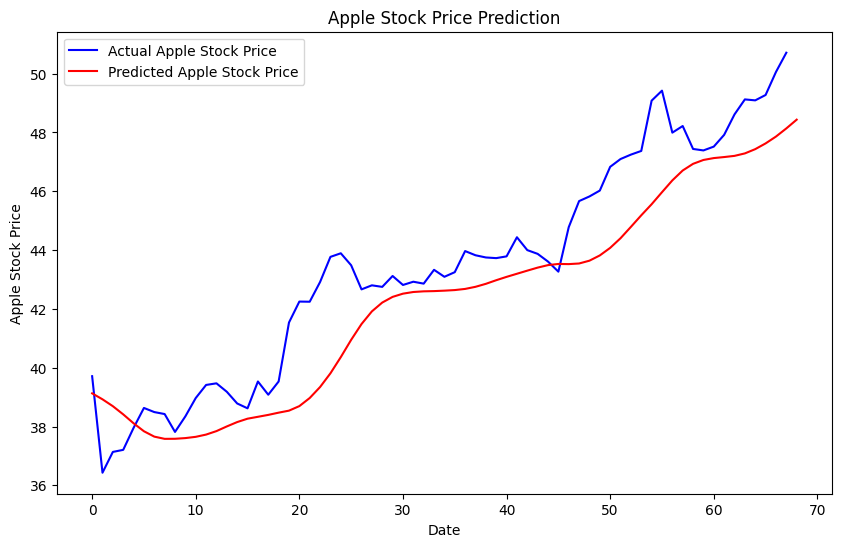

In [60]:
plt.figure(figsize=(10,6))
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [61]:
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)


test_inputs = test_stock_data_processed.reshape(-1,1)
test_inputs = sc.transform(test_inputs)


print(test_inputs.shape)

(68, 1)


In [62]:
test_features = []
for i in range(60, 291):
    test_features.append(test_inputs[i-60:i, 0])

test_features = np.array(test_features)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (231,) + inhomogeneous part.

In [63]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
print(test_features.shape)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
predicted_stock_price = model.predict(test_features)

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

In [ ]:
print(test_stock_data_processed.shape)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

## Download the model and the weights

In [ ]:
from google.colab import files

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
files.download("model.json")

In [ ]:
model.save('weights.h5')
files.download('weights.h5')